# Numba Stencil


Operasi stencil https://www.mathworks.com/help/parallel-computing/stencil-operations-on-a-gpu.html biasanya digunakan pada metode finite differences, finite elements, atau metode lain yang memanfaatkan suatu mesh atau grid.

## Persamaan Panas 1D

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \hspace{1em} x \in (0,L), t \in (0, T]
$$

dengan inisial awal $u(x,0) = I_0(x)$ dan syarat batas $u(0,t) = 0$ dan $u(L,t) = 0$.

Masalah ini dapat kita selesaikan dengan mendiskritisasi ruang dan waktunya (disebut juga dengan **metode finite difference**):

* **space discretisation:** $x_i = i\Delta x, i = 0, 1, \cdots, N_x$.
* **time discretisation:** $t_n = n\Delta t, t = 0, 1, \cdots, N_t$

dengan menggunakan **Central Time Central Space (CTCS)** atau dikenal sebagai metode **Crank-Nicolson 1D**

$$
\frac{w_i^{n+1} - w_i^n}{\Delta t} = \alpha \frac{w_{i+1}^n - 2w_i^n + w_{i-1}^n}{\Delta x^2}
$$

sehingga memebentuk

$$
w_i^{n+1} = w_i^n + F(w_{i+1}^n - 2w_i^n + w_{i-1}^n)
$$

dimana $F = \alpha \frac{\Delta t}{\Delta x^2}$.


![](../images/Heat1D.jpg)

Di dalam perhitungan grid terdapat $w_{i-1}, w_i, w_{i+1}$ yang disebut sebagai **3-titik stencil**.

![](../images/Stencil1D.jpg)

### Implementasi

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Nx = 500
Nt = 10_000
T = 100.
L = 100.

dx = L/Nx
dt = T/Nt
alpha = 1.0
F = alpha * dt/dx*dx

x = np.linspace(0, L, Nx+1)

# nilai awal: sin(2*pi*x) dimana 50 <= x <= 60
temp_awal = np.zeros(Nx+1)
temp_awal[Nx//2:Nx//2+Nx//10] = np.sin(2.0 * np.pi * (x[Nx//2:Nx//2+Nx//10] - x[Nx//2]) / (L/5) )

In [3]:
@numba.stencil
def Crank_Nicolson(x, F):
    return x[0] + F * (x[1] - 2.0 * x[0] + x[-1])

In [4]:
@numba.njit
def simulasi(x, F, Nt):
    for i in range(Nt):
        x = Crank_Nicolson(x, F)
    
    return x

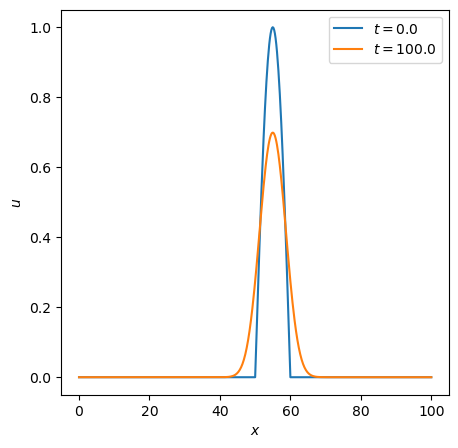

In [5]:
temp_simulasi = simulasi(temp_awal, F, Nt)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

ax.plot(x, temp_awal, label='$t = 0.0$')
ax.plot(x, temp_simulasi, label=f'$t = {T}$')

ax.legend()
plt.show()

### Widgets (Extra)

In [6]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [7]:
@widgets.interact(T=(1,1000))
def interaksi(T):
    x = np.linspace(0, L, Nx+1)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')

    ax.plot(x, temp_awal, label='$t = 0.0$')
    ax.plot(x, simulasi(temp_awal, F, int(T/dt)), label=f'$t = {T}$')

    ax.legend()

interactive(children=(IntSlider(value=500, description='T', max=1000, min=1), Output()), _dom_classes=('widget…

### Analisa Performa

**Python vs NumPy vs Numba**

In [8]:
# %time simulasi(temp_awal, F, Nt)

## Persamaan Panas 2D

$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right), \hspace{1em} x \in (0,L_x), y \in (0,L_y), t \in (0, T]
$$

dengan inisial awal $u(x,y,0) = I_0(x,y)$ dan syarat batas $u(0,t) = 0$ dan $u(L,t) = 0$.

Masalah ini dapat kita selesaikan dengan mendiskritisasi ruang dan waktunya (disebut juga dengan **metode finite difference**):

* **space discretisation $x$:** $x_i = i\Delta x, i = 0, 1, \cdots, N_x$.
* **space discretisation $y$:** $y_j = j\Delta y, j = 0, 1, \cdots, N_y$.
* **time discretisation:** $t_n = n\Delta t, t = 0, 1, \cdots, N_t$

dengan menggunakan **Central Time Central Space (CTCS)** atau dikenal sebagai metode **Crank-Nicolson 1D**

$$
w_{i,j}^{n+1} = w_{i,j}^n + \alpha \Delta t \left( \frac{w_{i-1,j}^n - 2w_{i,j}^n + w_{i+1,j}^n}{\Delta x^2} \right) + \alpha \Delta t \left( \frac{w_{i,j-1}^n - 2w_{i,j}^n + w_{i,j+1}^n}{\Delta y^2} \right) 
$$

sehingga memebentuk

$$
w_{i,j}^{n+1} = w_{i,j}^n + F_x (w_{i-1,j}^n - 2w_{i,j}^n + w_{i+1,j}^n) + F_y (w_{i,j-1}^n - 2w_{i,j}^n + w_{i,j+1}^n)
$$

dimana $F_x = \alpha \frac{\Delta t}{\Delta x^2}$ dan $F_y = \alpha \frac{\Delta t}{\Delta y^2}$.


![](../images/Heat2D.jpg)

Di dalam perhitungan grid terdapat $w_{i-1,j}, w_{i,j}, w_{i+1,j}, w_{i,j-1}, w_{i,j+1}$ yang disebut sebagai **5-titik stencil**.

![](../images/Stencil2D.jpg)

### Implementasi

In [15]:
Nx = 500
Ny = 500
Nt = 10_000
T = 100.
Lx = 100.
Ly = 100.

dx = Lx/Nx
dy = Ly/Ny
dt = T/Nt

alpha = 1.0
Fx = alpha * dt/dx*dx
Fy = alpha * dt/dy*dy

x,y = np.meshgrid(np.linspace(0, Lx, Nx+1), np.linspace(0, Ly, Ny+1), indexing='ij')

# nilai awal: exp^(-(x^2 - y^2)/2) dimana 50 <= x <= 60
temp_awal = np.zeros((Nx+1, Ny+1))
temp_awal = np.exp(-(x - Lx / 2.0)**2 / 2 - (y - Ly / 2.0)**2 / 2 ) # Nilai awal
temp_awal[(x == 0.0) | (y == 0.0) | (x == Lx) | (x == Ly)] = 0.0 # Syarat batas

In [16]:
@numba.stencil
def Crank_Nicolson(x, Fx, Fy):
    return x[0,0] + Fx * (x[-1,0] - 2.0 * x[0,0] + x[1,0]) + Fy * (x[0,-1] - 2.0 * x[0,0] + x[0,1])

In [17]:
@numba.njit
def simulasi(x, Fx, Fy, Nt):
    for i in range(Nt):
        x = Crank_Nicolson(x, Fx, Fy)
    
    return x

In [18]:
temp_simulasi = simulasi(temp_awal, Fx, Fy, Nt)

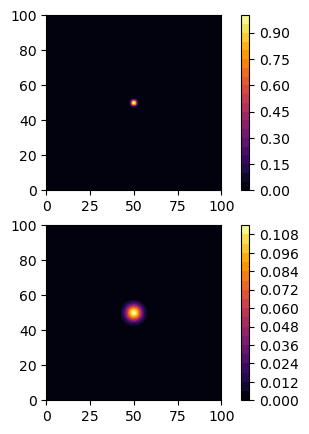

In [19]:
fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(211)
im1 = ax1.contourf(x, y, temp_awal, 20, cmap='inferno')
ax1.set_aspect('equal')
plt.colorbar(im1)

ax2 = fig.add_subplot(212)
im2 = ax2.contourf(x, y, temp_simulasi, 20, cmap='inferno')
ax2.set_aspect('equal')
plt.colorbar(im2)

plt.show()